In [15]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_standard_normal
from torchlake.image_generation.models import GanDiscriminator, GanGenerator
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/gan")
data_path = Path("../../data/fashionMnist")

In [4]:
device = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [7]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

100%|██████████| 26421880/26421880 [01:26<00:00, 306271.90it/s] 


Extracting ../../data/fashionMnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../../data/fashionMnist\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 92285.83it/s]


Extracting ../../data/fashionMnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../../data/fashionMnist\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:06<00:00, 683990.03it/s] 


Extracting ../../data/fashionMnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/fashionMnist\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 807489.79it/s]


Extracting ../../data/fashionMnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/fashionMnist\FashionMNIST\raw



In [8]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

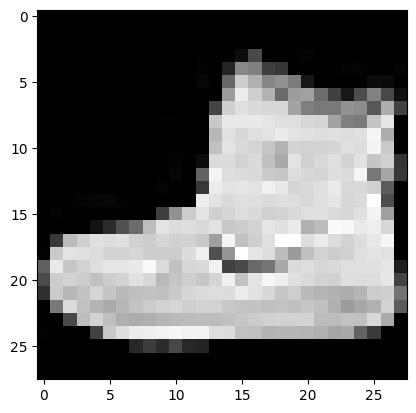

In [9]:
# 資料集繪圖
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

# train

In [10]:
generator = GanGenerator(128, 28).to(device)
discriminator = GanDiscriminator(28).to(device)

In [11]:
LR = 1e-4
BETA = (0.5, 0.999)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [13]:
epoches = 10

In [17]:
generator.train()
discriminator.train()
for e in range(epoches):
    running_loss_G = 0.0
    running_loss_D = 0.0

    for img, _ in tqdm(train_loader):
        img = img.to(device)

        valid = torch.ones(BATCH_SIZE, 1).to(device)
        fake = torch.zeros(BATCH_SIZE, 1).to(device)

        noise = generate_standard_normal(BATCH_SIZE, 128).to(device)

        optim_G.zero_grad()
        gen_img = generator(noise)
        g_loss = criterion(discriminator(gen_img), valid)
        g_loss.backward()
        optim_G.step()
        running_loss_G += g_loss.item()

        optim_D.zero_grad()
        real_loss = criterion(discriminator(img), valid)
        fake_loss = criterion(discriminator(gen_img.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D += d_loss.item()

    print(
        f"epoch {e+1}: D:{running_loss_D/len(train_data)} G:{running_loss_G/len(train_data)}"
    )

100%|██████████| 1875/1875 [00:31<00:00, 59.27it/s]


epoch 1: D:0.016283407065769036 G:0.03188509465704362


100%|██████████| 1875/1875 [00:26<00:00, 69.86it/s]


epoch 2: D:0.011512303107231855 G:0.04787049638926983


100%|██████████| 1875/1875 [00:26<00:00, 69.98it/s]


epoch 3: D:0.009712424853692453 G:0.055550620114803315


100%|██████████| 1875/1875 [00:30<00:00, 62.19it/s]


epoch 4: D:0.008677793376644453 G:0.06099498585760593


100%|██████████| 1875/1875 [00:28<00:00, 65.54it/s]


epoch 5: D:0.007838524582361181 G:0.06507299706240495


100%|██████████| 1875/1875 [00:26<00:00, 69.70it/s]


epoch 6: D:0.00696436956555893 G:0.07094455971618494


100%|██████████| 1875/1875 [00:28<00:00, 66.18it/s]


epoch 7: D:0.007544787337693076 G:0.07663262132207553


100%|██████████| 1875/1875 [00:27<00:00, 68.03it/s]


epoch 8: D:0.007838814238086344 G:0.06569883765478929


100%|██████████| 1875/1875 [00:29<00:00, 64.42it/s]


epoch 9: D:0.006373048413855334 G:0.08183813631931941


100%|██████████| 1875/1875 [00:28<00:00, 66.87it/s]

epoch 10: D:0.005502004644367844 G:0.08729267160097758


# evaluation

In [27]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(device)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 1875/1875 [00:14<00:00, 132.94it/s]

0.8180333333333333


In [28]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_standard_normal(BATCH_SIZE, 128).to(device)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 1875/1875 [00:14<00:00, 128.21it/s]

0.0006666666666666666


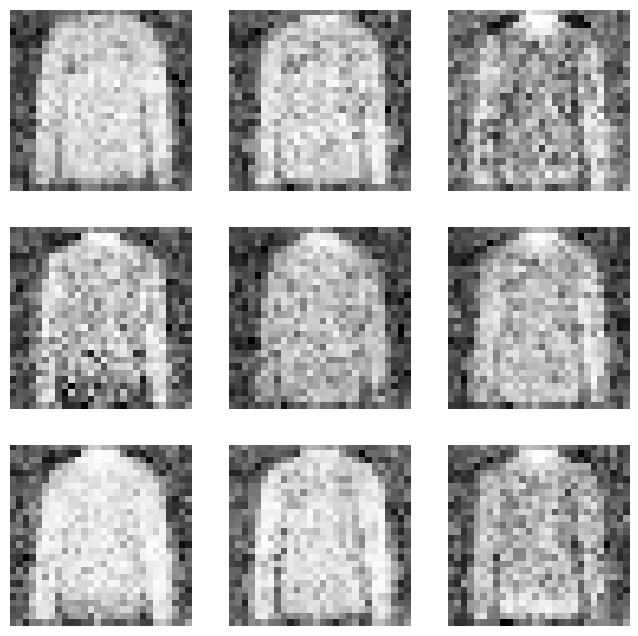

In [32]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_standard_normal(9, 128).to(device)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=3,
        num_col=3,
        is_gray_scale=True,
    )

In [34]:
model_path = artifact_path / 'gan.pth'

In [35]:
torch.save(generator.state_dict(), model_path.as_posix())